In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA

In [253]:
ticker = "NVDA"  # Example: Apple stock
df = yf.download(ticker, start="2020-01-01", end="2025-02-01")
df = df[['Close']]  # Focus on closing prices
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,NVDA
Date,
2020-01-02,5.972712
2020-01-03,5.877111
2020-01-06,5.901759
2020-01-07,5.973208
2020-01-08,5.984411


In [254]:

df.columns = df.columns.droplevel(1)  # Drops the second index level ("Ticker")
df = df.rename_axis(None, axis=1)  # Removes the column name
print(df.head())  # Check the updated DataFrame

               Close
Date                
2020-01-02  5.972712
2020-01-03  5.877111
2020-01-06  5.901759
2020-01-07  5.973208
2020-01-08  5.984411


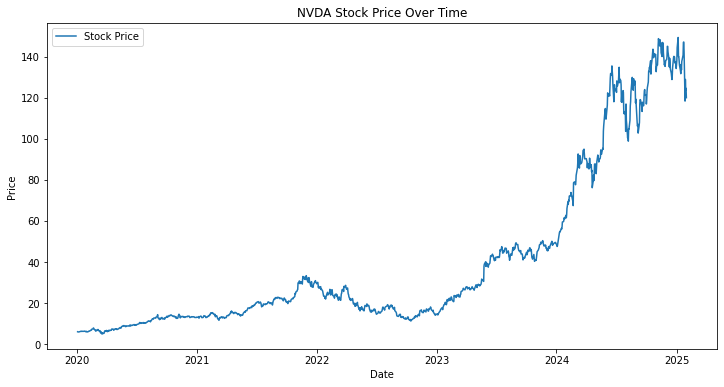

In [255]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Stock Price')
plt.title(f"{ticker} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [256]:
df["Close"] = np.log(df["Close"])

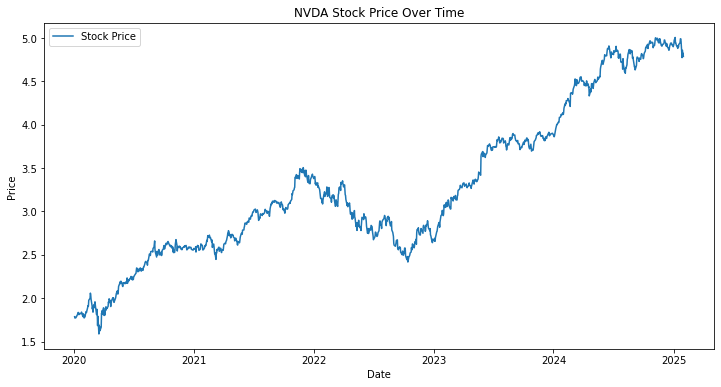

In [257]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Stock Price')
plt.title(f"{ticker} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [258]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The data is stationary (reject H0)")
    else:
        print("The data is not stationary (fail to reject H0)")

adf_test(df['Close'])

ADF Statistic: -0.6767974864640909
p-value: 0.8526683267759102
The data is not stationary (fail to reject H0)


ADF Statistic: -10.924456971606718
p-value: 1.0185027065947215e-19
The data is stationary (reject H0)


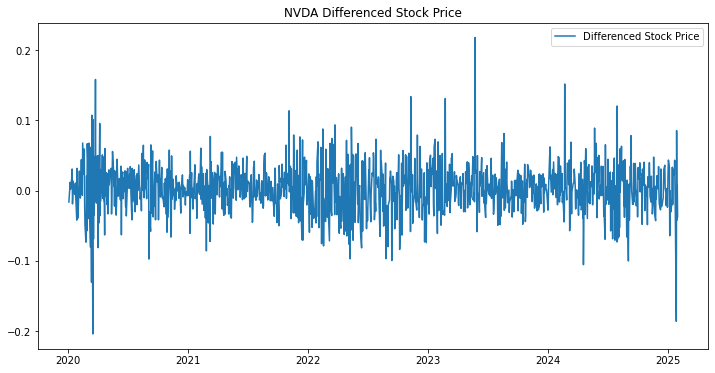

In [259]:
df['Close_diff'] = df['Close'].diff()
adf_test(df['Close_diff'].dropna())

plt.figure(figsize=(12,6))
plt.plot(df['Close_diff'], label='Differenced Stock Price')
plt.title(f"{ticker} Differenced Stock Price")
plt.legend()
plt.show()

In [260]:
adf_test(df['Close_diff'])

ADF Statistic: -10.924456971606718
p-value: 1.0185027065947215e-19
The data is stationary (reject H0)


In [261]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [262]:

def add_lags(df):
    target_map = df['Close'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('35 Days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('70 days')).map(target_map)
    return df

df = add_lags(df)

In [263]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [264]:


tss = TimeSeriesSplit(n_splits=5, test_size=90, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2']
    TARGET = 'Close'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:2.22132	validation_1-rmse:3.11721
[100]	validation_0-rmse:0.82791	validation_1-rmse:1.48671
[200]	validation_0-rmse:0.32135	validation_1-rmse:0.93969
[300]	validation_0-rmse:0.14259	validation_1-rmse:0.77170
[400]	validation_0-rmse:0.08786	validation_1-rmse:0.66181


c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.07023	validation_1-rmse:0.63380
[600]	validation_0-rmse:0.06333	validation_1-rmse:0.61906
[700]	validation_0-rmse:0.05908	validation_1-rmse:0.61645
[718]	validation_0-rmse:0.05843	validation_1-rmse:0.61667
[0]	validation_0-rmse:2.30850	validation_1-rmse:3.30019
[100]	validation_0-rmse:0.86237	validation_1-rmse:1.42859
[200]	validation_0-rmse:0.33650	validation_1-rmse:0.60769
[300]	validation_0-rmse:0.15435	validation_1-rmse:0.28898
[400]	validation_0-rmse:0.09800	validation_1-rmse:0.19343
[500]	validation_0-rmse:0.08060	validation_1-rmse:0.16912


c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[600]	validation_0-rmse:0.07326	validation_1-rmse:0.15830
[700]	validation_0-rmse:0.06884	validation_1-rmse:0.14563
[800]	validation_0-rmse:0.06439	validation_1-rmse:0.14415
[819]	validation_0-rmse:0.06338	validation_1-rmse:0.14351
[0]	validation_0-rmse:2.41323	validation_1-rmse:3.81169
[100]	validation_0-rmse:0.90015	validation_1-rmse:1.98786
[200]	validation_0-rmse:0.34940	validation_1-rmse:1.26422
[300]	validation_0-rmse:0.15956	validation_1-rmse:0.99034
[400]	validation_0-rmse:0.09976	validation_1-rmse:0.88967


c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.08167	validation_1-rmse:0.84441
[600]	validation_0-rmse:0.07409	validation_1-rmse:0.82848
[700]	validation_0-rmse:0.06954	validation_1-rmse:0.82567
[800]	validation_0-rmse:0.06513	validation_1-rmse:0.81394
[900]	validation_0-rmse:0.06132	validation_1-rmse:0.81107
[930]	validation_0-rmse:0.06035	validation_1-rmse:0.81227
[0]	validation_0-rmse:2.54077	validation_1-rmse:4.22305
[100]	validation_0-rmse:0.94730	validation_1-rmse:1.90449
[200]	validation_0-rmse:0.36624	validation_1-rmse:0.95464
[300]	validation_0-rmse:0.16488	validation_1-rmse:0.57571
[400]	validation_0-rmse:0.10315	validation_1-rmse:0.43651


c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.08517	validation_1-rmse:0.37994
[600]	validation_0-rmse:0.07734	validation_1-rmse:0.36128
[700]	validation_0-rmse:0.07264	validation_1-rmse:0.35096
[800]	validation_0-rmse:0.06864	validation_1-rmse:0.34682
[900]	validation_0-rmse:0.06593	validation_1-rmse:0.34310
[999]	validation_0-rmse:0.06356	validation_1-rmse:0.34164
[0]	validation_0-rmse:2.69783	validation_1-rmse:4.37294
[100]	validation_0-rmse:1.00392	validation_1-rmse:1.81984
[200]	validation_0-rmse:0.38609	validation_1-rmse:0.81346
[300]	validation_0-rmse:0.16998	validation_1-rmse:0.44234
[400]	validation_0-rmse:0.10284	validation_1-rmse:0.31571
[500]	validation_0-rmse:0.08315	validation_1-rmse:0.28210


c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[600]	validation_0-rmse:0.07490	validation_1-rmse:0.26922
[700]	validation_0-rmse:0.07015	validation_1-rmse:0.26605
[706]	validation_0-rmse:0.06993	validation_1-rmse:0.26634


In [265]:


print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')



Score across folds 0.4351
Fold scores:[0.6152990658998243, 0.14266166945080447, 0.8101446979762761, 0.3416051217106026, 0.265540806933994]


In [266]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2']
TARGET = 'Close'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:2.88249
[100]	validation_0-rmse:1.07099
[200]	validation_0-rmse:0.40973
[300]	validation_0-rmse:0.17897
[400]	validation_0-rmse:0.10893


c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[499]	validation_0-rmse:0.08754


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [267]:


df.index




DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2025-01-17', '2025-01-21', '2025-01-22', '2025-01-23',
               '2025-01-24', '2025-01-27', '2025-01-28', '2025-01-29',
               '2025-01-30', '2025-01-31'],
              dtype='datetime64[ns]', name='Date', length=1278, freq=None)

In [268]:

df.head()
df.columns
df.index.max()


Timestamp('2025-01-31 00:00:00')

In [269]:
import pandas as pd
import numpy as np

# Get last available date in df
last_date = df.index.max()

# Create future dataframe
future = pd.date_range('2025-01-01','2025-10-01', freq='B')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

df

,Close,Close_diff,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture
Date,,,,,,,,,,,,
2020-01-02,1.787201,NaN,3,1,1,2020,2,2,1,NaN,NaN,False
2020-01-03,1.771065,-0.016136,4,1,1,2020,3,3,1,NaN,NaN,False
2020-01-06,1.775250,0.004185,0,1,1,2020,6,6,2,NaN,NaN,False
2020-01-07,1.787284,0.012034,1,1,1,2020,7,7,2,NaN,NaN,False
2020-01-08,1.789158,0.001874,2,1,1,2020,8,8,2,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-27,4.774238,-0.185946,0,1,1,2025,27,27,5,4.939282,4.942644,False
2025-01-28,4.859735,0.085497,1,1,1,2025,28,28,5,4.943213,4.990432,False
2025-01-29,4.817859,-0.041876,2,1,1,2025,29,29,5,NaN,4.982784,False


In [270]:


future_w_features = df_and_future.query('isFuture').copy()





In [271]:


df_and_future['pred'] = reg.predict(df_and_future[FEATURES])



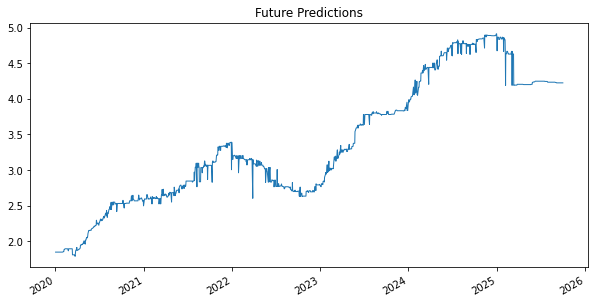

In [272]:


df_and_future['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()



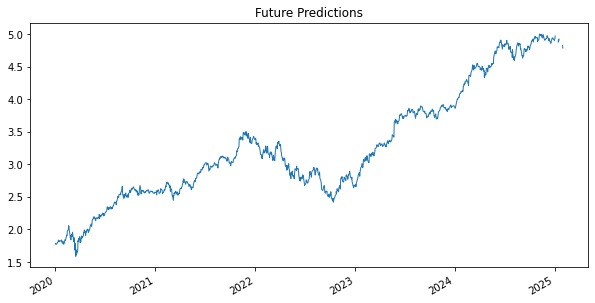

In [273]:
df_and_future['Close'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

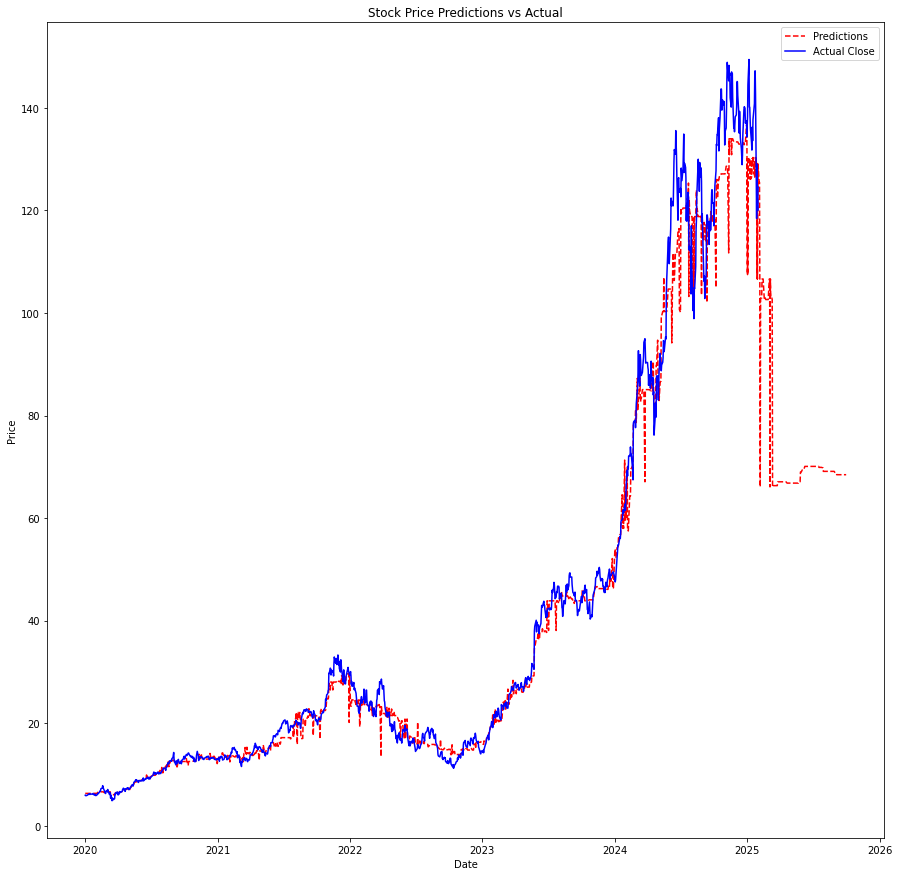

In [274]:
plt.figure(figsize=(15, 15))

# Plot both 'pred' and 'Close' on the same graph
plt.plot(df_and_future.index, np.e**df_and_future['pred'], label='Predictions', color='red', linestyle='--')
plt.plot(df_and_future.index, np.e**df_and_future['Close'], label='Actual Close', color='blue')

# Labels and title
plt.title('Stock Price Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [275]:
ticker = "NVDA"  # Example: Apple stock
df = yf.download(ticker, start="2020-01-01", end="2025-02-01")
df = df[['Close']]  # Focus on closing prices
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,NVDA
Date,
2020-01-02,5.972712
2020-01-03,5.877111
2020-01-06,5.901759
2020-01-07,5.973208
2020-01-08,5.984411


In [276]:
df["Close"] = np.log(df["Close"])

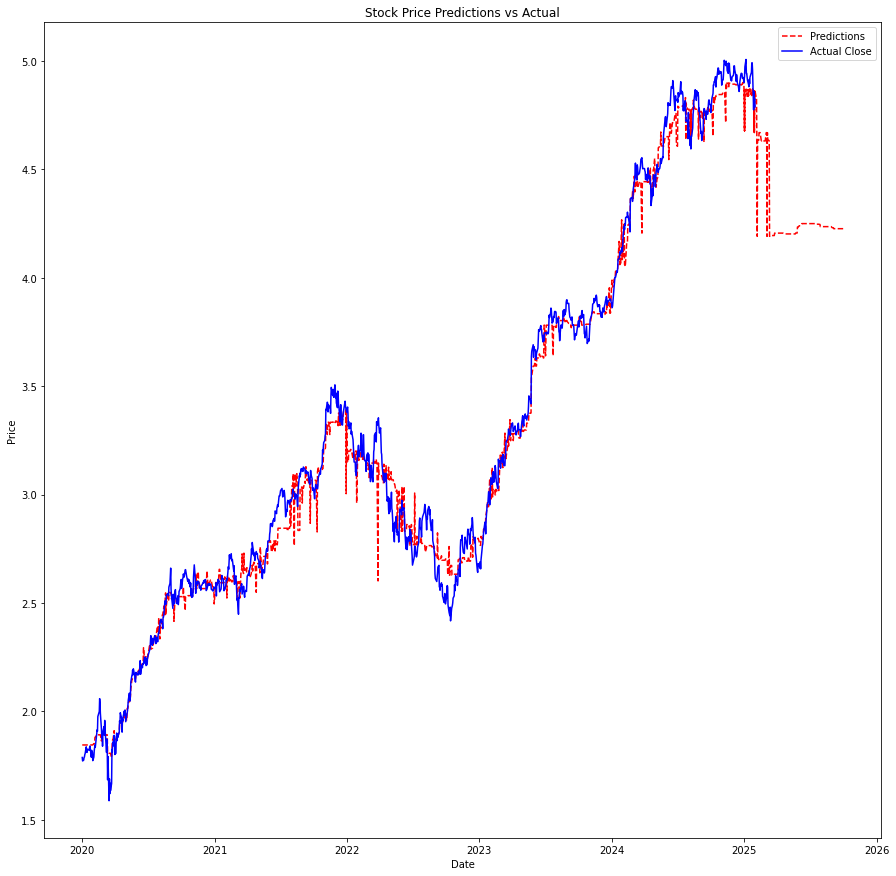

In [277]:
plt.figure(figsize=(15, 15))

# Plot both 'pred' and 'Close' on the same graph
plt.plot(df_and_future.index, df_and_future['pred'], label='Predictions', color='red', linestyle='--')
plt.plot(df['Close'], label='Actual Close', color='blue')

# Labels and title
plt.title('Stock Price Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()